### Assumptions
+ Mom & Pop Investors are long term value based investors looking to gain wealth over time
+ They want to spend little to no time checking the returns and balancing once a quarter if needed
+ They want to focus on fundamental factor models, for e.g. GreenBlatt's Magic Formula, which ranks companies based on fundamental ratios. 
+ Fractional Trading is allowed/ trade stocks with fractional trading enabled
+ Wants to be able to diversify investments across different stocks. 
+ Universe for the backtest of the strategy is S&P 500 for the last 6 years of data, meaning any company that has existed in the S&P 500 is part of our selection to avoid 'Survivorship Bias'


### Things to track
+ Sharpe Ratio
+ Portfolio Analysis
+ vs Benchmark (S&P 500?!)
+ Absolute Returns and Annualised Returns.

### Productise 
+ Based on themes
+ Asks for portfolio value they want to invest so that the algorithm can tell them which stocks to buy 
+ if stocks already in existing portfolio, they can upload with following columns - Stock Name, Number of Shares (fractional allowed), Dollar amount invested. Then the algorithm would give them the rebalance portfolio and how many shares to be sold.
+ If no portfolio selected then they can use the theme to generate a portfolio based on the theme selected and number of stocks in their portfolio. 

In [1]:
import snowflake.connector
import pandas as pd
from dotenv import load_dotenv
import os
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
from dateutil.relativedelta import relativedelta

load_dotenv()
SNF_USER = os.getenv('snf_user')
SNF_PASSWORD = os.getenv('snf_password')
SNF_ACCOUNT = os.getenv('snf_account_name')
SNF_WAREHOUSE = os.getenv('snf_warehouse')
SNF_DATABASE = os.getenv('snf_db')
SCHEMA = 'public'

# Create a connection to Snowflake
conn = snowflake.connector.connect(
    user=SNF_USER,
    password=SNF_PASSWORD,
    account=SNF_ACCOUNT,
    warehouse=SNF_WAREHOUSE,
    database=SNF_DATABASE,
    schema=SCHEMA
)
# SQL query to select data from the table as its monthly data so rolling it up to a quarterly data
query = """SELECT
  *
FROM
    MODEL_DATA 
QUALIFY row_number() over (
        partition by symbol,
        quarter_end
        order by
            date desc
    ) = 1
order by
    symbol,
    date desc;"""

# Execute the query and load the results into a pandas DataFrame
df = pd.read_sql(query, conn)

# Close the connection
conn.close()

# Display the DataFrame
df.head()  # Show the first few rows of the DataFrame

/var/folders/h2/4vckn0v11xs13gyyr0n4rx740000gn/T/ipykernel_93342/111338365.py:43: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


,QUARTER_END,SYMBOL,DATE,OPEN,HIGH,LOW,CLOSE,ADJCLOSE,VOLUME,UNADJUSTEDVOLUME,...,PRICEEARNINGSRATIO,PRICETOFREECASHFLOWSRATIO,PRICETOOPERATINGCASHFLOWSRATIO,PRICECASHFLOWRATIO,PRICEEARNINGSTOGROWTHRATIO,PRICESALESRATIO,DIVIDENDYIELD,ENTERPRISEVALUEMULTIPLE,PRICEFAIRVALUE,TARGET
0,2023-12-31,A,2023-12-29,139.07,139.70,138.36,139.03,139.03,1014431,1014400,...,15.940742,70.109745,58.696531,58.696531,0.048460,17.942778,0.002179,62.365893,5.181764,-6.42
1,2023-09-30,A,2023-09-29,113.12,113.17,111.45,111.82,111.41,1830100,1830100,...,80.905743,74.682225,63.918416,63.918416,-1.289435,21.484539,0.001837,164.679075,6.463143,-7.56
2,2023-06-30,A,2023-06-30,118.73,120.69,118.30,120.25,119.81,2487900,2487900,...,33.456755,118.521290,101.547136,101.547136,-2.341973,23.538591,0.001633,88.927458,6.991136,1.26
3,2023-03-31,A,2023-03-31,135.40,138.73,134.86,138.34,137.34,2579800,2579800,...,32.079375,205.308000,152.593784,152.593784,-7.955685,25.721959,0.001483,93.403904,8.052730,-2.10
4,2022-12-31,A,2022-12-30,149.76,149.85,147.83,149.65,148.57,699800,699800,...,28.008356,109.069577,92.027455,92.027455,2.200657,22.297620,0.001504,77.938838,7.795103,1.62


In [ ]:
print(f"Number of rows and columns: {df.shape},and number of unique companies in df: {df['SYMBOL'].nunique()}")

### calculate quarterly returns

In [2]:
df.sort_values(by=['SYMBOL', 'DATE'], inplace=True)

# Convert 'DATE' and 'QUARTER_END' to datetime 
df['DATE'] = pd.to_datetime(df['DATE'])
df['QUARTER_END'] = pd.to_datetime(df['QUARTER_END'])

# Group by 'SYMBOL' and 'QUARTER_END' to calculate the first and last 'ADJCLOSE' in each group
df['ADJCLOSE_START'] = df.groupby('SYMBOL')['ADJCLOSE'].shift(1)
df['ADJCLOSE_END'] = df["ADJCLOSE"]

# Calculate quarterly return for each row
df['QUARTERLY_RETURN'] = (df['ADJCLOSE_END'] - df['ADJCLOSE_START']) / df['ADJCLOSE_START']


In [3]:
print(f"Number of rows and columns: {df.shape},and number of unique companies in df: {df['SYMBOL'].nunique()}")

Number of rows and columns: (13668, 109),and number of unique companies in df: 596


### ranking


In [4]:
# Step 0: Preprocessing to handle infinities and zeros in PRICEEARNINGSRATIO
df['PRICEEARNINGSRATIO'] = df['PRICEEARNINGSRATIO'].replace({0: np.nan}) 
df['EARNINGS_YIELD'] = 1 / df['PRICEEARNINGSRATIO']
df['ROC'] = df['RETURNONCAPITALEMPLOYED']
df.replace([np.inf, -np.inf], np.nan, inplace=True)  # Replace infinities with NaN


In [39]:

# Function to select top companies based on Greenblatt's formula each quarter
def select_top_companies(sub_df, top_n=30):
    sub_df['RANK_EY'] = sub_df['EARNINGS_YIELD'].rank(ascending=False)
    sub_df['RANK_ROC'] = sub_df['ROC'].rank(ascending=False)
    sub_df['COMBINED_RANK'] = (sub_df['RANK_EY'] + sub_df['RANK_ROC']) / 2
    return sub_df.nsmallest(top_n, 'COMBINED_RANK')

# # Step 2: Rank and select companies each quarter
top_companies_per_quarter = df.groupby('QUARTER_END').apply(select_top_companies)

# # # Step 3: Portfolio construction and quarterly return calculation
top_companies_per_quarter.drop(['QUARTER_END'], axis = 1, inplace=True)
top_companies_per_quarter['PORTFOLIO_WEIGHT'] = 1 / top_companies_per_quarter.groupby('QUARTER_END')['SYMBOL'].transform('count') # equal weightage
top_companies_per_quarter['QUARTERLY_PORTFOLIO_RETURN'] = top_companies_per_quarter['QUARTERLY_RETURN'] * top_companies_per_quarter['PORTFOLIO_WEIGHT']
quarterly_portfolio_returns = top_companies_per_quarter.groupby('QUARTER_END')['QUARTERLY_PORTFOLIO_RETURN'].sum()


/var/folders/h2/4vckn0v11xs13gyyr0n4rx740000gn/T/ipykernel_93342/3750557140.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_companies_per_quarter = df.groupby('QUARTER_END').apply(select_top_companies)


In [40]:
top_companies_per_quarter.reset_index()["SYMBOL"].nunique()

204

#### Cumulative returns

In [41]:
quarterly_portfolio_returns = pd.DataFrame(quarterly_portfolio_returns)
quarterly_portfolio_returns['CUMULATIVE_RETURN'] = (np.ones_like(quarterly_portfolio_returns)+ quarterly_portfolio_returns).cumprod() -1

In [42]:
quarterly_portfolio_returns

,QUARTERLY_PORTFOLIO_RETURN,CUMULATIVE_RETURN
QUARTER_END,,
2018-03-31,0.000000,0.000000
2018-06-30,0.001435,0.001435
2018-09-30,0.000073,0.001508
2018-12-31,-0.208943,-0.207749
2019-03-31,0.090588,-0.135981
2019-06-30,0.048699,-0.093904
2019-09-30,0.014017,-0.081203
2019-12-31,0.103011,0.013443
2020-03-31,-0.282518,-0.272873


#### Annualised Return 
You might notice that we are not just averaging quarterly returns and multiplying it by 4. We are taking into account the reinvesting of the profits. It is based on the concept of compounding returns over multiple periods. This approach takes into account the effect of earnings being reinvested at the end of each quarter and generating additional earnings in subsequent quarters. It's a more accurate reflection of how returns accumulate over time, especially when dealing with variable quarterly returns.

On the other hand, simply calculating the mean quarterly return and multiplying it by 4 (to annualize it) assumes a constant return rate for each quarter and does not account for compounding. This method might give you an approximation but can significantly understate or overstate returns when the quarterly returns are volatile or significantly varied.

In [43]:
annualized_return = (1 + quarterly_portfolio_returns['QUARTERLY_PORTFOLIO_RETURN']).prod() ** (4 / len(quarterly_portfolio_returns)) - 1


In [44]:
# average returns which doesn't take into effect the compounding and reinvesting of those profits. 
print(f"Average returns are: {(quarterly_portfolio_returns['QUARTERLY_PORTFOLIO_RETURN'].mean()*4)*100}")

Average returns are: 20.32913385235915


In [45]:
print(f"The annualised return of the portfolio is {annualized_return*100} %")

The annualised return of the portfolio is 18.802107155938796 %


### Compare with S&P 500 returns 

##### Quarterly Returns

[*********************100%%**********************]  1 of 1 completed
/var/folders/h2/4vckn0v11xs13gyyr0n4rx740000gn/T/ipykernel_93342/3854390830.py:5: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  sp500_data['Quarterly Return'] = sp500_data['Adj Close'].resample('Q').ffill().pct_change()


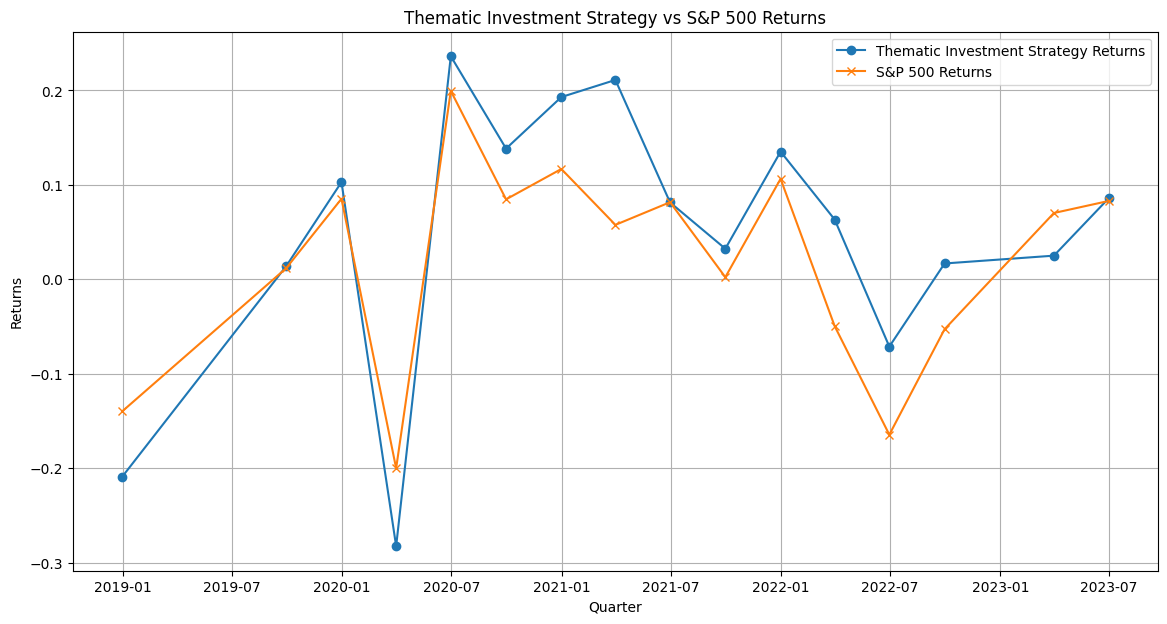

In [46]:
# Fetch S&P 500 historical data
sp500_data = yf.download('^GSPC', start='2018-03-31', end='2023-12-31')

# Calculate quarterly returns
sp500_data['Quarterly Return'] = sp500_data['Adj Close'].resample('Q').ffill().pct_change()

# Ensure both DataFrames have a common 'Quarter' column for merging
sp500_returns = sp500_data[['Quarterly Return']].dropna()
sp500_returns.rename(columns={'Quarterly Return': 'S&P 500 Returns'}, inplace=True)

# Merge with strategy returns that we calculated earlier
comparison_df = pd.merge(quarterly_portfolio_returns, sp500_returns, left_index=True, right_index=True, how='inner')

# Plotting
plt.figure(figsize=(14, 7))
plt.plot(comparison_df.index, comparison_df['QUARTERLY_PORTFOLIO_RETURN'], label='Thematic Investment Strategy Returns', marker='o')
plt.plot(comparison_df.index, comparison_df['S&P 500 Returns'], label='S&P 500 Returns', marker='x')
plt.title('Thematic Investment Strategy vs S&P 500 Returns')
plt.xlabel('Quarter')
plt.ylabel('Returns')
plt.legend()
plt.grid(True)
plt.show()


[*********************100%%**********************]  1 of 1 completed
/var/folders/h2/4vckn0v11xs13gyyr0n4rx740000gn/T/ipykernel_93342/2775685720.py:5: FutureWarning: 'Q' is deprecated and will be removed in a future version, please use 'QE' instead.
  sp500_quarterly_prices = sp500_data['Adj Close'].resample('Q').ffill()


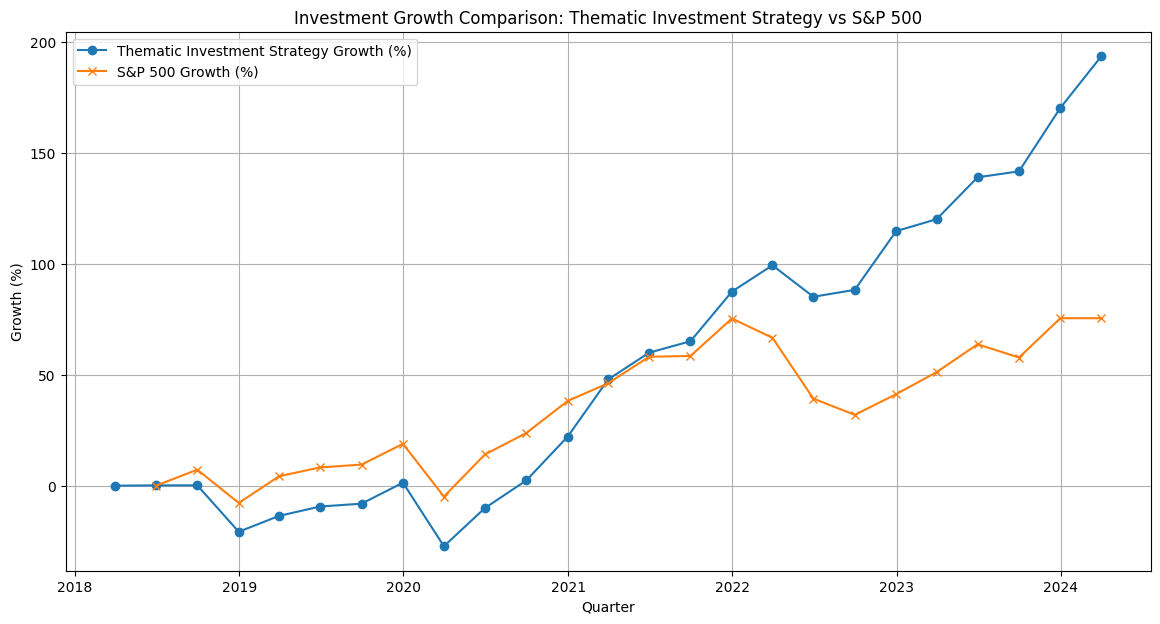

In [47]:
# Fetch S&P 500 historical data
sp500_data = yf.download('^GSPC', start='2018-03-31', end='2023-12-31')

# Calculate the adjusted close price at the end of each quarter
sp500_quarterly_prices = sp500_data['Adj Close'].resample('Q').ffill()

# Calculate the percentage change for visualization
sp500_quarterly_growth = (sp500_quarterly_prices / sp500_quarterly_prices.iloc[0]) - 1

# The strategy we built earlier's cumulative return
strategy_growth = quarterly_portfolio_returns['CUMULATIVE_RETURN']

# Ensure both series are aligned on the same date index
sp500_quarterly_growth = sp500_quarterly_growth.reindex(strategy_growth.index, method='ffill')

# Plotting the growth comparison
plt.figure(figsize=(14, 7))
plt.plot(strategy_growth.index, strategy_growth * 100, label='Thematic Investment Strategy Growth (%)', marker='o')
plt.plot(sp500_quarterly_growth.index, sp500_quarterly_growth * 100, label='S&P 500 Growth (%)', marker='x')
plt.title('Investment Growth Comparison: Thematic Investment Strategy vs S&P 500')
plt.xlabel('Quarter')
plt.ylabel('Growth (%)')
plt.legend()
plt.grid(True)
plt.show()


In [48]:
annualized_return_s_p500= ((sp500_data["Adj Close"][-1]/sp500_data["Adj Close"][0]) ** (1/5.75) -1) * 100
print(f"The annualised return of our strategy is {round(annualized_return*100, 2)} vs for S&P 500 (buy and hold): {round(annualized_return_s_p500, 2)}")

The annualised return of our strategy is 18.8 vs for S&P 500 (buy and hold): 11.27


/var/folders/h2/4vckn0v11xs13gyyr0n4rx740000gn/T/ipykernel_93342/3138922245.py:1: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  annualized_return_s_p500= ((sp500_data["Adj Close"][-1]/sp500_data["Adj Close"][0]) ** (1/5.75) -1) * 100


The annual return of 18.8% is generally considered very good which beats the market by 7% approx on an annualised return. Let's analyse how good is it when we measure the risk of the portfolio. 

## Risk Metrics
Ideally we would need daily data to calculate these risk metrics. For simplification of the problem we would assume that we are only concerned at quarterly performance and not intra-quarter performance metrics. In real world, you would perhaps want to calculate these metrics using the daily data. 


#### Volatility

In [49]:
volatility = quarterly_portfolio_returns['QUARTERLY_PORTFOLIO_RETURN'].std() * np.sqrt(4)  # Annualize the volatility


In [50]:
print(f"The annualised volatility of the portfolio is {volatility*100}% indicating high variability and some level of risk inherent in the strategy with a potential to earn greater profit")

The annualised volatility of the portfolio is 23.157236890818687% indicating high variability and some level of risk inherent in the strategy with a potential to earn greater profit


#### Sharpe Ratio 
- The Sharpe ratio evaluates the performance of an investment compared to a risk-free asset, after adjusting for its risk.

In [51]:
risk_free_rate = 0.02  # Assume a risk-free rate of 2%
sharpe_ratio = (annualized_return - risk_free_rate) / volatility


In [52]:
sharpe_ratio

0.7255661474275649

#### Max drawdown

In [53]:
print(f" The portfolio on a quarterly basis has a max drawdown of: {quarterly_portfolio_returns['QUARTERLY_PORTFOLIO_RETURN'].min()* 100} %" )
print("----------------")
print("You'd also notice that its during the peak of the pandemic (March 2020)")

 The portfolio on a quarterly basis has a max drawdown of: -28.25177957954396 %
----------------
You'd also notice that its during the peak of the pandemic (March 2020)


In [54]:
quarterly_portfolio_returns.reset_index()[quarterly_portfolio_returns.reset_index()['QUARTERLY_PORTFOLIO_RETURN']==quarterly_portfolio_returns.reset_index()['QUARTERLY_PORTFOLIO_RETURN'].min()]

,QUARTER_END,QUARTERLY_PORTFOLIO_RETURN,CUMULATIVE_RETURN
8,2020-03-31,-0.282518,-0.272873


#### Tear Sheet (Metrics and Values)

In [55]:
num_of_years_backtest = (relativedelta(pd.to_datetime(quarterly_portfolio_returns.reset_index()["QUARTER_END"]).max(), pd.to_datetime(quarterly_portfolio_returns.reset_index()["QUARTER_END"]).min()).years )

In [57]:
tear_sheet = pd.DataFrame(columns= ["Metric", "Value"])

tear_sheet["Metric"] = ["Annualized Return(%)","Absolute Returns(%)", "Sharpe Ratio", "Max Drawdown(%)", "Volatily(%)", 
                        "Backtest (Years)" ]
tear_sheet["Value"] = [annualized_return*100, quarterly_portfolio_returns["CUMULATIVE_RETURN"][-1]*100, 
                       sharpe_ratio, quarterly_portfolio_returns['QUARTERLY_PORTFOLIO_RETURN'].min()* 100, volatility, int(num_of_years_backtest)]

/var/folders/h2/4vckn0v11xs13gyyr0n4rx740000gn/T/ipykernel_93342/655492464.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  tear_sheet["Value"] = [annualized_return*100, quarterly_portfolio_returns["CUMULATIVE_RETURN"][-1]*100,


In [58]:
tear_sheet

,Metric,Value
0,Annualized Return(%),18.802107
1,Absolute Returns(%),193.528921
2,Sharpe Ratio,0.725566
3,Max Drawdown(%),-28.251780
4,Volatily(%),0.231572
5,Backtest (Years),6.000000


### Conclusion 
The portfolio using a thematic investment strategy like Greenblatt's Magic formula which ranks companies based on ROC, and Earnings yield provides a good annualised return (18% wohu!) but that comes with a higher risk with Sharpe ratio less than <1. A high sharpe ratio can be used to judge the profitability of the portfolio adjusted with risk it takes. 

Further exploration can be done to enhance these metrics and possibly create multiple theme based strategies. There could be a way to build a machine learning model that uses these features and perhaps increase the sharpe ratio and still hold those returns.

Another assumption we made is that we used the quarterly returns to calculate these risk metrics as we are only going to rebalance the portfolio every quarter to make it easy for a mom and pop investor. 

All in all, its my take to read the data from financial modelling prep, upload to a data warehouse, then read from there to build a simple trading strategy. You could use this to create a data product like a stock screener, or even launch a theme based investment portfolio which creates these themes and then allow a mom & pop investor to invest freely with buy and hold strategies that have survived the test of markets in the long run.